In [1]:
%reset -f
%matplotlib inline
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import os
import rpy2.robjects as ro
import pylab as pl
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from tick.preprocessing.features_binarizer import FeaturesBinarizer
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from QNEM.inference import QNEM
from load_Data_forCox import load_Data_forCox
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

## Load data
dataFrame index on OfficialID, drop=True

In [2]:
X, Y, delta = load_Data_forCox()
X.head()

,gender,age,t_stage_mod_6is4_7is1,n_stage,UICC_TNM,postop_chemo,nlnode,plnode,sidedness,ascending,transverse,descending,sigmoid,differentiation,mucinous_colloide,occlusion,perforation,venous_emboli,lymphatic_invasion,perineural_invasion,msi_gen,p53_status,kras_status,apc_status,braf_status,pi3k_status,Immunoscore
OfficialID,,,,,,,,,,,,,,,,,,,,,,,,,,,
PAR170,0,34.08,3,1.0,III,1,43.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
PAR171,0,84.48,4,0.0,II,0,13.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
PAR172,1,61.05,4,2.0,III,0,21.0,4.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
PAR173,0,75.51,3,1.0,III,0,7.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
PAR174,0,94.07,3,0.0,II,0,15.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## Dividing in train and test set

In [3]:
X.index = np.arange(X.shape[0])
delta.index = np.arange(X.shape[0])
Y.index = np.arange(X.shape[0])

## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X.loc[test_index]
    delta_test = delta.loc[test_index]
    Y_test = Y.loc[test_index]

    X = X.loc[train_index]
    Y = Y.loc[train_index]
    delta = delta.loc[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Retrouver la p_value du test de Wald avec l'immunoscore univarié

In [4]:
df=X[['Immunoscore']].astype(np.int8)
df["Y"] = Y
df["delta"] = delta
df.dtypes

Immunoscore       int8
Y              float64
delta            int64
dtype: object

In [5]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='Y', event_col='delta')
cph.print_summary()

n=207, number of events=42

               coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Immunoscore -0.9072     0.4036    0.2599 -3.4913 0.0005     -1.4165     -0.3979  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.646


### C-index in prediction on the test set

In [6]:
X_test_immunoscore = X_test[['Immunoscore']].astype(np.int8)
hat_beta = cph.summary.coef
marker_test = X_test_immunoscore.dot(hat_beta)
c_index = concordance_index(np.ravel(Y_test), marker_test, np.ravel(delta_test))
c_index = max(c_index, 1 - c_index)
print("C-index on test set: %.2f" % c_index)

C-index on test set: 0.59


## Modèles de survie multivarié et comparaison du C-index en prédiction

In [7]:
X, Y, delta = load_Data_forCox()

X.index = np.arange(X.shape[0])
delta.index = np.arange(X.shape[0])
Y.index = np.arange(X.shape[0])

In [8]:
X_cont = X[["age", "nlnode", "plnode"]]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X_cont), columns=X_cont.columns)
X.drop(["age", "nlnode", "plnode"], axis=1, inplace=True)

binarizer = FeaturesBinarizer(remove_first=True)
X_bin = binarizer.fit_transform(X)
X_bin = X_bin.todense()
blocks_start = binarizer.blocks_start
blocks_length = binarizer.blocks_length

columns_names = []
for i in range(X.shape[1]):
    for j in range(1, blocks_length[i]):
        columns_names += [X.columns[i] + "=" + str(j)]
        
X_bin = pd.DataFrame(X_bin, columns=columns_names)
X = pd.concat([X_cont,X_bin], axis=1)

## TODO: 
Je te laisse creuser un peu le code de binarization, ça te permettra de bien le maitriser et de bien comprendre ce qui est fait. Ce qu'il faut c'est retrouver les vrais valeurs des catégories plutôt que de mettre `str(j)` dans les columns_names ds le code au dessus, de façon à pouvoir interpréter correctement ensuite.

In [9]:
## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X.loc[test_index]
    delta_test = delta.loc[test_index]
    Y_test = Y.loc[test_index]

    X = X.loc[train_index]
    Y = Y.loc[train_index]
    delta = delta.loc[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


In [10]:
df = X.copy()
df["Y"] = Y
df["delta"] = delta

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='Y', event_col='delta')
cph.print_summary()

n=207, number of events=42

                            coef          exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
age                       0.3541             1.4249    0.2207  1.6044 0.1086     -0.0785      0.7867     
nlnode                   -0.4729             0.6232    0.2893 -1.6345 0.1022     -1.0399      0.0942     
plnode                    0.7123             2.0386    0.2200  3.2374 0.0012      0.2811      1.1435   **
gender=1                 -0.2924             0.7465    0.3829 -0.7637 0.4451     -1.0428      0.4580     
t_stage_mod_6is4_7is1=1  13.4409        687567.9480  474.0308  0.0284 0.9774   -915.6425    942.5243     
t_stage_mod_6is4_7is1=2  28.0834 1572044958939.0122 1546.7711  0.0182 0.9855  -3003.5323   3059.6991     
t_stage_mod_6is4_7is1=3  28.6492 2768277332243.5752 1546.7712  0.0185 0.9852  -3002.9665   3060.2650     
n_stage=1                 6.8977           990.0000       nan     nan    nan         nan         nan     
n_stage=2         

## Result in prediction

In [11]:
hat_beta = cph.summary.coef
marker_test = X_test.dot(hat_beta)
c_index = concordance_index(np.ravel(Y_test), marker_test, np.ravel(delta_test))
c_index = max(c_index, 1 - c_index)
print("C-index on test set: %.2f" % c_index)

C-index on test set: 0.62


### donc simplement en prenant en compte toutes les variables cliniques que l'on a encodé, on améliore le C-index de prédiction en passant de 0.59 à 0.62.

Reste maintenant à travailler sur les images avec les différentes méthodes d'extraction: c'est là dessus que le potentiel est énorme pour améliorer les performances.

## Elastic-net Cox 

Voici le code pour entraîner un cox avec une pénalité Elastic-Net, qui te sera très utile puisque la dimension du problème va significativement augmenter.

On fait appel au package glmnet (https://web.stanford.edu/~hastie/Papers/v39i05.pdf) de R depuis ce notebook python grâce au package rpy2 qu'il te faut installer.

## TODO: 
mettre Y en jours (ce sera des entiers c'est mieux) et remplacer les Y=0 par Y=1 jour car Y=0 pose pb ds la plapart des modèles

In [12]:
# je remplace ici les Y=0 par Y=1 jours
Y[Y==0] = 1/30

In [13]:
%R -i X,Y,delta
%R library(survival)
%R library(ggfortify)
%R library(glmnet)
%R Y = as.numeric(data.matrix(Y))
%R delta = as.numeric(data.matrix(delta))
%R cv = cv.glmnet(as.matrix(X),\
                  Surv(time=Y, event=delta, type="right"),\
                  family="cox",\
                  alpha=.9)
#%R gammaChosen = cv$lambda.1se
%R gammaChosen = cv$lambda.min
%R fit <- glmnet(as.matrix(X),\
                 Surv(time=Y,event=delta,type="right"),\
                 lambda=gammaChosen,\
                 family="cox",\
                 alpha=.9)
%R coeffs <- as.vector(fit$beta)
%R -o coeffs

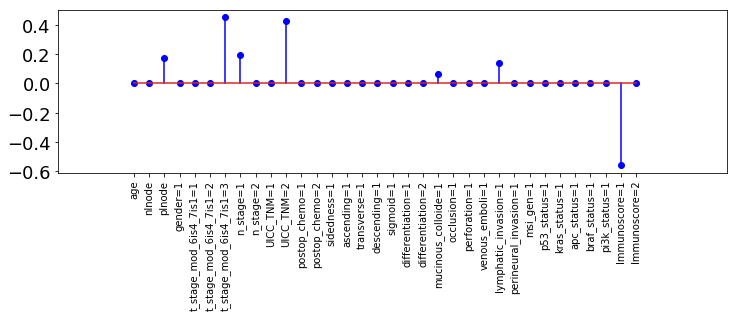

In [21]:
hat_beta_cox_EL = np.array(coeffs)

fig = pl.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
ax.stem(hat_beta_cox_EL, 'b', markerfmt='bo')
ax.set_xlim([-5, len(hat_beta_cox_EL) + 5])
pl.yticks(fontsize = 18)
pl.xticks(np.arange(len(hat_beta_cox_EL)), X.columns, rotation=90)
pl.show()

## TODO: 
essayer de faire tourner un Cox classique (CoxPHFitter) sur le support du $\beta$ Elastic-Net (i.e. en gardant que les variables dont le coeff est non nul) et voir si ça améliore les prédictions.

# C-mix model 
Il faut que tu installes le package en suivant les indications ici https://github.com/SimonBussy/C-mix

In [36]:
n_samples, n_features = X.shape

X = np.array(X)
Y = np.ravel(Y)
delta = np.ravel(delta)
X_test = np.array(X_test)
Y_test = np.ravel(Y_test)
delta_test = np.ravel(delta_test)

tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
fit_intercept = True  # whether or not an intercept term is fitted
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'
verbose = True 

## Choose between C-mix or CURE model ##
model = "C-mix"  # "C-mix", "CURE"       

if verbose:
    print("\nLaunching %s...\n" % model)

learner = QNEM(l_elastic_net=0., eta=eta, max_iter=100, tol=tol, 
               warm_start=warm_start, verbose=verbose, model=model, 
               fit_intercept=fit_intercept)
learner.n_features = n_features         

## Cross-validation ##
learner.cross_validate(X, Y, delta, n_folds=5, verbose=False, eta=eta, 
                       grid_size=grid_size, metric=metric)
avg_scores = learner.scores.mean(axis=1)
l_elastic_net_best = learner.l_elastic_net_best
if gamma_chosen == '1se':
    l_elastic_net_chosen = learner.l_elastic_net_chosen
if gamma_chosen == 'min':
    l_elastic_net_chosen = l_elastic_net_best
    
grid_elastic_net = learner.grid_elastic_net # get the cross-validation grid 
                                            # to plot learning curves

## Run selected model with l_elasticNet_chosen ##
learner = QNEM(l_elastic_net=l_elastic_net_chosen, eta=eta, tol=tol,
               warm_start=warm_start, verbose=verbose, model=model,
               fit_intercept=fit_intercept)
learner.n_features = n_features
learner.fit(X, Y, delta) 


Launching C-mix...

Testing l_elastic_net=5.71e-05 on fold  0 1 2 3 4: avg_score=5.92e-01
Testing l_elastic_net=7.85e-05 on fold  0 1 2 3 4: avg_score=6.14e-01
Testing l_elastic_net=1.08e-04 on fold  0 1 2 3 4: avg_score=6.59e-01
Testing l_elastic_net=1.48e-04 on fold  0 1 2 3 4: avg_score=6.14e-01
Testing l_elastic_net=2.03e-04 on fold  0 1 2 3 4: avg_score=7.01e-01
Testing l_elastic_net=2.80e-04 on fold  0 1 2 3 4: avg_score=6.30e-01
Testing l_elastic_net=3.84e-04 on fold  0 1 2 3 4: avg_score=6.72e-01
Testing l_elastic_net=5.28e-04 on fold  0 1 2 3 4: avg_score=5.94e-01
Testing l_elastic_net=7.25e-04 on fold  0 1 2 3 4: avg_score=6.60e-01
Testing l_elastic_net=9.96e-04 on fold  0 1 2 3 4: avg_score=6.13e-01
Testing l_elastic_net=1.37e-03 on fold  0 1 2 3 4: avg_score=6.85e-01
Testing l_elastic_net=1.88e-03 on fold  0 1 2 3 4: avg_score=7.09e-01
Testing l_elastic_net=2.58e-03 on fold  0 1 2 3 4: avg_score=6.58e-01
Testing l_elastic_net=3.55e-03 on fold  0 1 2 3 4: avg_score=7.09e-01

In [40]:
## Obtain the marker vector on test set ##
coeffs = learner.coeffs
marker_test = QNEM.predict_proba(X_test, fit_intercept, coeffs) 
c_index = concordance_index(Y_test, marker_test, delta_test)
c_index = max(c_index, 1 - c_index)
print("C-index on test set: %.2f" % c_index)

C-index on test set: 0.65


## Donc le C-mix améliore encore les perfs